In [131]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


#prepare object points and image points for caliberation

objp = np.zeros((6*9,3),np.float32)
#fill up with points from (0,0,0) .....(8,5,0)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)


#Arrays to store object & image points from images
obj_points=[]
img_points=[]

#read caliberation examples with globe
images = glob.glob('camera_cal/calibration*.jpg')



print("finding corners on given images......")
#steps to search corners we iterate through images
for idx, fname in enumerate(images):

    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #find the corners
    ret , corners = cv2.findChessboardCorners(gray,(9,6) ,None)

    #if ret true then draw corners on chessboard and save it to a file
    if ret ==True:
        print('workin on ',fname)
        #append points to array placeholders 
        obj_points.append(objp)
        img_points.append(corners)
        
        #Draw chessboard corners on original image and save it to a file
        cv2.drawChessboardCorners(img,(9,6),corners,ret)
        cv2.imwrite('./camera_cal/caliberation_corners'+str(idx)+'.jpg',img)

img = cv2.imread('./camera_cal/caliberation_corners10.jpg')
print("finding corners completed and pickle file is saved")



finding corners on given images......
workin on  camera_cal/calibration10.jpg
workin on  camera_cal/calibration11.jpg
workin on  camera_cal/calibration12.jpg
workin on  camera_cal/calibration13.jpg
workin on  camera_cal/calibration14.jpg
workin on  camera_cal/calibration15.jpg
workin on  camera_cal/calibration16.jpg
workin on  camera_cal/calibration17.jpg
workin on  camera_cal/calibration18.jpg
workin on  camera_cal/calibration19.jpg
workin on  camera_cal/calibration2.jpg
workin on  camera_cal/calibration20.jpg
workin on  camera_cal/calibration3.jpg
workin on  camera_cal/calibration6.jpg
workin on  camera_cal/calibration7.jpg
workin on  camera_cal/calibration8.jpg
workin on  camera_cal/calibration9.jpg
finding corners completed and pickle file is saved


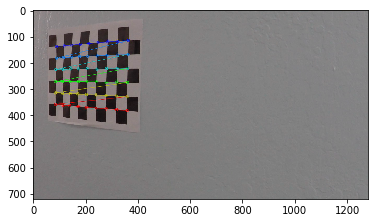

In [132]:
#make sure we found corners
img = cv2.imread('./camera_cal/caliberation_corners10.jpg')

plt.imshow(img)


In [133]:
import pickle
# w,h = img.shape
#Caliberate and create a pickle file to save calibrated mtx and distance values
imgsize = (img.shape[1],img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, imgsize,None,None)

# Save 
dist_pickle = {} #empty dictionary
dist_pickle["mtx"] = mtx 
dist_pickle["dist"] = dist
filename = './camera_cal/calib_dist_mtx.p'
pickle.dump( dist_pickle, open( filename, "wb" ) )

print("mtx and dist are dumped into pickle file as {} ".format(filename))

mtx and dist are dumped into pickle file as ./camera_cal/calib_dist_mtx.p 


In [134]:
#helper function to undistort and transofrm
def plot_points(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img,cmap='gray')
    plt.title('source points chosen manually')
    plt.plot(800,500,'o') #topright
    plt.plot(1120,700,'o') #bottomright
    plt.plot(540,500,'o') #topleft
    plt.plot(270,700,'o') #bottomleft


def subplot_images(img1,img2,title1,title2):
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1,cmap='gray')
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2,cmap='gray')
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def cal_undistort(img, mtx, dist):
    # grayscale first
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

#warp image to get a bird eye view
def warp(img,dst,src):
    #grayscale image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1],gray.shape[0])
    src = np.float32([[270,700],[540,500],[1120,700],[800,500]])
    dst = np.float32([[270,700],[270,500],[1120,700],[1120,500]])
    M = cv2.getPerspectiveTransform(src,dst)
    minV = cv2.getPerspectiveTransform(dst,src) 
    warped = cv2.warpPerspective(img,M,img_size, flags = cv2.INTER_LINEAR)
    return warped,M ,minV

#unwarp image to original perspective
def unwarp(warp_img,minV):
    img_size = (warp_img.shape[1],warp_img.shape[0])
    unwarped = cv2.warpPerspective(warp_img,minV,img_size, flags = cv2.INTER_LINEAR)
    return unwarped

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    import numpy as np

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if(orient == 'x'):
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0)
    if(orient == 'y'):
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_label = np.uint8(255*abs_sobel/np.max(abs_sobel))
    

    # 6) Return this mask as your binary_output image
    
    binary_output =np.zeros_like(scaled_label)
    binary_output[(scaled_label >= thresh_min) & (scaled_label <= thresh_max)]=1
    return binary_output


# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    # 3) Calculate the magnitude
    magnitude = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = (np.max(magnitude)/255).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    mask = np.zeros_like(scaled)
    mask[(scaled>mag_thresh[0])&(scaled<mag_thresh[1])] =1
    # 6) Return this mask as your binary_output image
    binary_output = mask 
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    magnitx = np.absolute(sobelx)
    magnity = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan = np.arctan2(magnity,magnitx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(arctan)
    binary_output[(arctan>= thresh[0])&(arctan<= thresh[1])]=1
    # 6) Return this mask as your binary_output image
    return binary_output


# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(50, 300)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary = np.zeros_like(s)
    binary[(s > thresh[0])&(s<= thresh[1])] = 1 # placeholder line
    return binary

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids



        

In [135]:
#load pickle for mtx and dist to be used later for undistort
calib_dist = pickle.load(open(filename,"rb"))
mtx = calib_dist["mtx"]
dist = calib_dist["dist"]

In [136]:
#load test images and iterate over each to undistort and warp

test_imgs = glob.glob('test_images/*.jpg')


for idx, fname in enumerate(test_imgs):
    #pipeline begins here: goal is to undistort and 
    #warp lane line images bird eye view
    img = cv2.imread(fname)
    print('workin on ',fname)  
    undist = cal_undistort(img, mtx, dist)

    
#     cv2.imwrite('./warped_imgs/warped'+str(idx)+'.jpg',res)


workin on  test_images/straight_lines1.jpg
workin on  test_images/straight_lines2.jpg
workin on  test_images/test1.jpg
workin on  test_images/test2.jpg
workin on  test_images/test3.jpg
workin on  test_images/test4.jpg
workin on  test_images/test5.jpg
workin on  test_images/test6.jpg


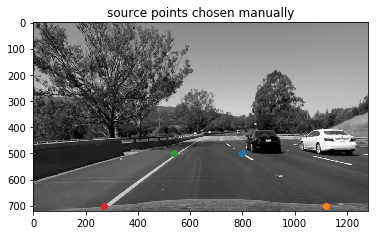

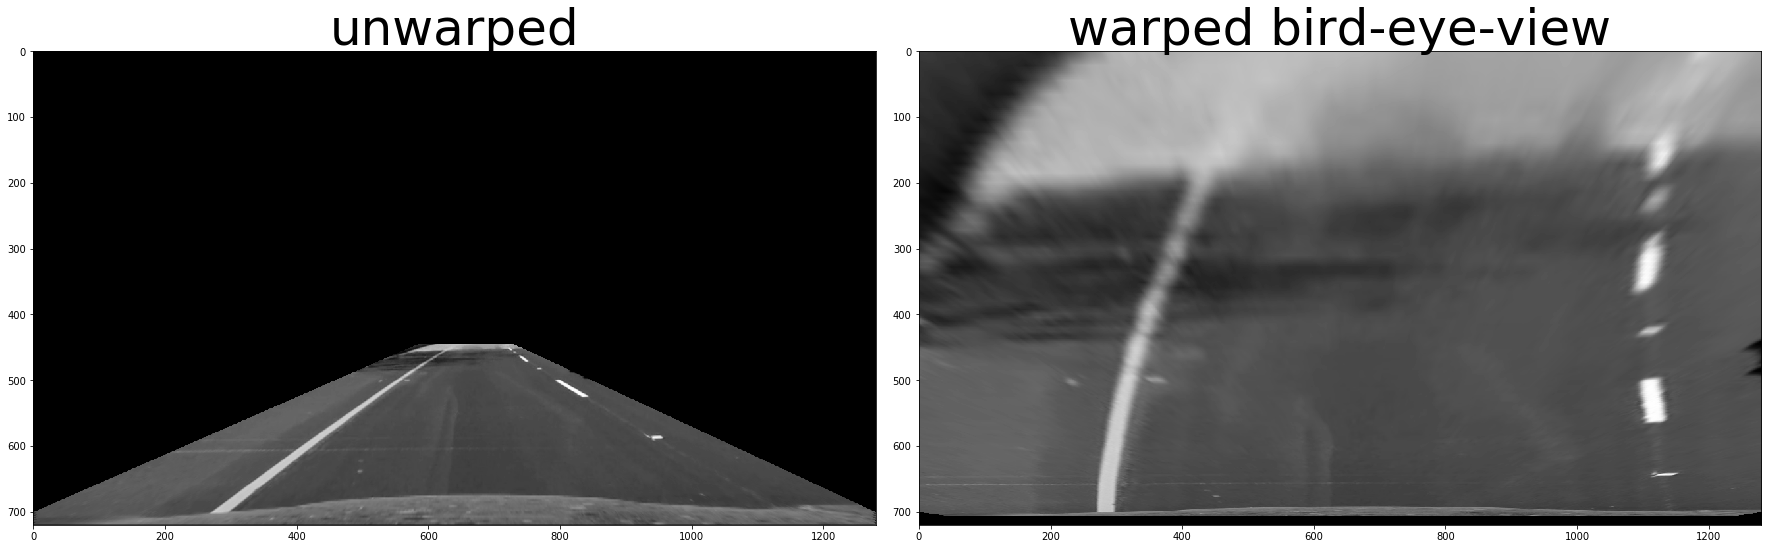

In [149]:
#test undist and warp before feeding all images
tst_img = cv2.imread('./test_images/test4.jpg')

#undistort
w = cal_undistort(tst_img,mtx,dist)

#manually calculated points for source and warped destination image

src = np.float32([[270,700],[540,500],[1120,700],[800,500]])
dst = np.float32([[270,700],[270,500],[1120,700],[1120,500]])

#draw manually calculated points on image
plot_points(undist)

#warp image bird-eye-view/top down
warp_img ,M , minV = warp(undist ,src,dst)

unwarp_img = unwarp(warp_img,minV)

subplot_images(unwarp_img,warp_img,"unwarped","warped bird-eye-view")

#

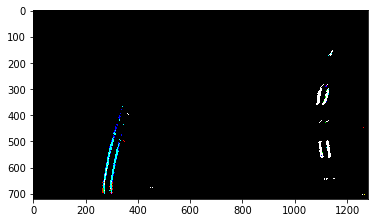

In [150]:
sobelx = cv2.Sobel(warp_img, cv2.CV_64F, 1, 0)
absx = np.absolute(sobelx)
scaled_sobel = np.uint8(255*absx/np.max(absx))
output_sobel = np.zeros_like(sobelx)
thresh = (50,155)
output_sobel[(scaled_sobel > thresh[0])&(scaled_sobel <= thresh[1])] = 1
plt.imshow(output_sobel, cmap='gray')



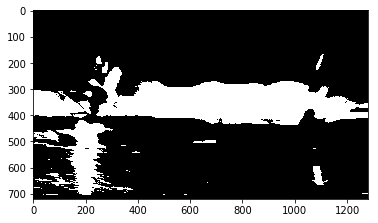

In [152]:
#test undist and warp before feeding all images
tst_img = cv2.imread('./test_images/test5.jpg')

#undistort
w = cal_undistort(tst_img,mtx,dist)
#warp image bird-eye-view/top down
warp_img ,M , minV = warp(w ,src,dst)

unwarp_img = unwarp(warp_img,minV)

binary = hls_select(warp_img)

plt.imshow(binary, cmap='gray')


array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

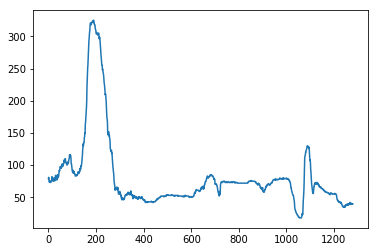

In [153]:
histogram = np.sum(binary[int(binary.shape[0]/2):,:], axis=0)
plt.plot(histogram)

#exploare histogram to find two possible peaks to fit polynomial
binary[np.where(binary>0)]

In [154]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary, binary, binary))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary.shape[0] - (window+1)*window_height
    win_y_high = binary.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

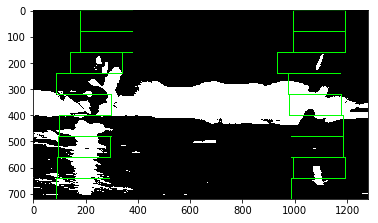

In [155]:
plt.imshow(out_img, cmap='gray')

(720, 0)

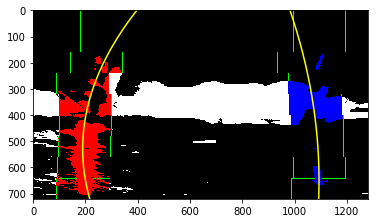

In [156]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [157]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

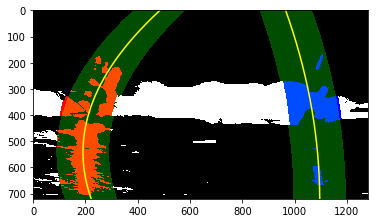

In [158]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary, binary, binary))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [159]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

597.00187872 2043.12873635


In [160]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

165.02527963 m 671.046538385 m


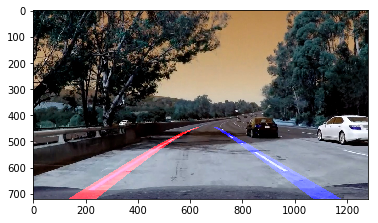

In [161]:
left_lane = np.array(list(zip(np.concatenate((left_fitx-margin/2,left_fitx[::-1]+margin/2),axis=0),np.concatenate((ploty,ploty[::-1]),axis=0))),np.int32)
right_lane = np.array(list(zip(np.concatenate((right_fitx-margin/2,right_fitx[::-1]+margin/2),axis=0),np.concatenate((ploty,ploty[::-1]),axis=0))),np.int32)
road = np.zeros_like(tst_img)
road_bkg = np.zeros_like(tst_img)
cv2.fillPoly(road,[left_lane], color=[255,0,0])
cv2.fillPoly(road,[right_lane], color=[0,0,255])
cv2.fillPoly(road_bkg,[left_lane], color=[255,0,0])
cv2.fillPoly(road_bkg,[right_lane], color=[0,0,255])

road  = unwarp(road,minV)
road_bk = unwarp(road_bk,minV)
base = cv2.addWeighted(tst_img,1.0,road_bk,-1.0,0.0)
base = cv2.addWeighted(tst_img,1.0,road,2.0,0.0)


plt.imshow(base)


